## SISTEMA INTELIGENTE DE DETECCIÓN DE FUGA DE CLIENTES



* DARIO ALEJANDRO TUL TEO
* JOSE JAVIER BONILLA SALAZAR
* JOSUE DANIEL FUENTES DIAZ
* SERGIO ANDRES LARIOS FAJARDO
* YESHUA DAVID INAY RAMOS

El proyecto “Sistema Inteligente de Detección de Fuga de Clientes” tiene como objetivo predecir la probabilidad de que un cliente abandone (churn) una compañía de telecomunicaciones utilizando técnicas de Machine Learning.

Este sistema permite a la empresa anticipar la pérdida de clientes y tomar decisiones informadas para retenerlos, demostrando el impacto práctico de la inteligencia artificial y el aprendizaje automático en negocios reales.

# Carga de Dataset
Revision del dataset, identificamos columnas relevantes, clases, desbalances. Se hace una limpieza inicial. Codificacion/normalizacion cuando se necesito. Division train/test. Tambien revision de distribuciones y correlaciones. Se identifican las relaciones entre variables.

Entrenamiento SVM con varios C, arboles de decision y Naïve Bayes.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Cargar dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Eliminar columna customerID
df = df.drop('customerID', axis=1)

# Reemplazar espacios vacíos en TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Convertir columnas categóricas a números
df = pd.get_dummies(df, drop_first=True)

# Separar variables
X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

# Split de entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# GridSearch
param_grid = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(class_weight='balanced'),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Entrenamiento con busqueda
grid.fit(X_train, y_train)

svm_model = grid.best_estimator_
print("Mejores parámetros:", grid.best_params_)

y_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Mejores parámetros: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.765791341376863
              precision    recall  f1-score   support

       False       0.91      0.75      0.83      1036
        True       0.54      0.80      0.64       373

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.81      0.77      0.78      1409



# Comparacion de Metricas

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Función para evaluar un modelo
def evaluar_modelo(modelo, X_test, y_test, nombre):
    y_pred = modelo.predict(X_test)
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }

# Lista donde guardaremos todos los resultados
resultados = []

#   1. SVM (Tu modelo optimizado)
resultados.append(evaluar_modelo(svm_model, X_test, y_test, "SVM Optimizado"))

#   2. Árbol de Decisión
from sklearn.tree import DecisionTreeClassifier
modelo_arbol = DecisionTreeClassifier(class_weight="balanced", random_state=42)
modelo_arbol.fit(X_train, y_train)

resultados.append(evaluar_modelo(modelo_arbol, X_test, y_test, "Decision Tree"))

#   3. KNN
from sklearn.neighbors import KNeighborsClassifier
modelo_knn = KNeighborsClassifier(n_neighbors=5)
modelo_knn.fit(X_train, y_train)

resultados.append(evaluar_modelo(modelo_knn, X_test, y_test, "KNN (k=5)"))

#   4. Random Forest
from sklearn.ensemble import RandomForestClassifier
modelo_rf = RandomForestClassifier(class_weight="balanced", random_state=42)
modelo_rf.fit(X_train, y_train)

resultados.append(evaluar_modelo(modelo_rf, X_test, y_test, "Random Forest"))

#   Convertir resultados a tabla
df_resultados = pd.DataFrame(resultados)
df_resultados


,Modelo,Accuracy,Precision,Recall,F1-score
0,SVM Optimizado,0.765791,0.539020,0.796247,0.642857
1,Decision Tree,0.737402,0.504021,0.504021,0.504021
2,KNN (k=5),0.770050,0.572271,0.520107,0.544944
3,Random Forest,0.794890,0.660305,0.463807,0.544882


# Feature Importances (Random Forest)
La grafica representa las variables que mas influyen en que un cliente se vaya (churn). Mide cuanto contribuye cada variable a las predicciones. Permite proponer acciones basada en datos.

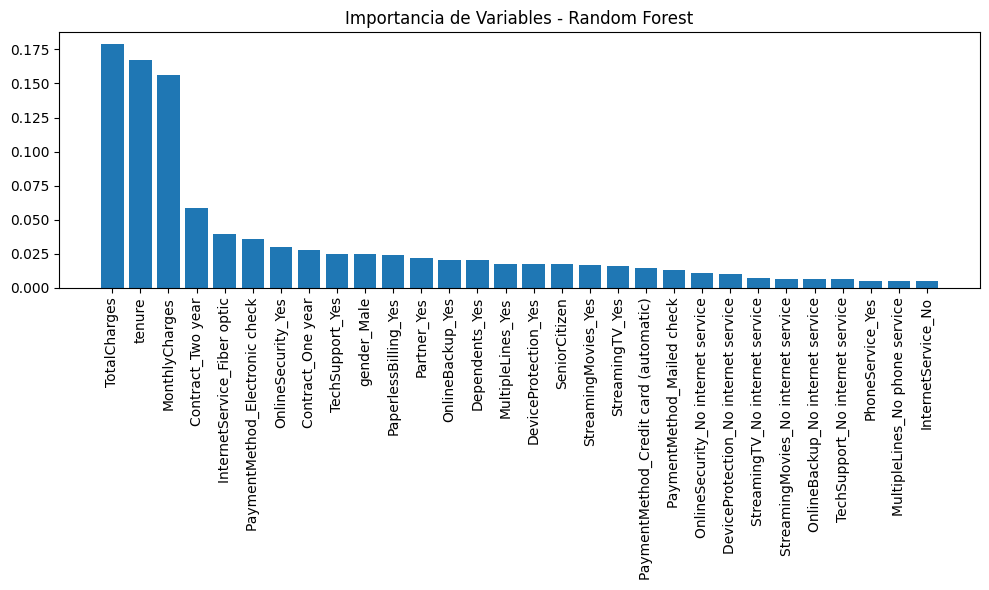

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importancia de características del Random Forest
importances = modelo_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10,6))
plt.title("Importancia de Variables - Random Forest")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

## DASHBOARD


**Importaciones**

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**Datos Necesarios**

In [ ]:
# Copia del dataset procesado
df_dashboard = df.copy()

# Feature Importance (Random Forest)
importances = modelo_rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(10)

# Predicciones del modelo Random Forest para las métricas
rf_pred = modelo_rf.predict(X_test)

# Métricas del modelo
acc = accuracy_score(y_test, rf_pred)
prec = precision_score(y_test, rf_pred)
rec = recall_score(y_test, rf_pred)
f1 = f1_score(y_test, rf_pred)

**Churn vs No Churn**

In [ ]:
churn_data = df_dashboard["Churn_Yes"].value_counts().reset_index()
churn_data.columns = ['Churn_Status', 'Count'] # Rename columns for clarity

fig1 = px.bar(
    churn_data,
    x="Churn_Status", y="Count",
    labels={"Churn_Status": "Churn", "Count": "Cantidad"},
    title="Distribución de Churn"
)
fig1.show()

**Churn por tipo de contrato**

In [ ]:
contract_df = df_dashboard.groupby("Contract_Two year")["Churn_Yes"].mean().reset_index()

fig2 = px.bar(
    contract_df, x="Contract_Two year", y="Churn_Yes",
    title="Churn por Tipo de Contrato",
    labels={"Contract_Two year": "Contrato de dos años", "Churn_Yes": "Tasa de Churn"}
)
fig2.show()


**Cargos mensuales vs churn**

In [ ]:
fig3 = px.box(
    df_dashboard,
    x="Churn_Yes",
    y="MonthlyCharges",
    title="Distribución de Monthly Charges según Churn",
    labels={"Churn_Yes": "Churn", "MonthlyCharges": "Monthly Charges"}
)
fig3.show()


**Feature Importance del Random Forest**

In [ ]:
fig4 = px.bar(
    importance_df.sort_values("Importance", ascending=True),
    x="Importance", y="Feature",
    orientation="h",
    title="Importancia de las Características (Random Forest)"
)
fig4.show()


**Indicadores del modelo Random Forest**

In [ ]:
fig_metrics = make_subplots(
    rows=1, cols=4,
    specs=[[{"type": "indicator"}]*4],
    subplot_titles=("Accuracy", "Precision", "Recall", "F1-score")
)

fig_metrics.add_trace(go.Indicator(mode="number", value=acc), row=1, col=1)
fig_metrics.add_trace(go.Indicator(mode="number", value=prec), row=1, col=2)
fig_metrics.add_trace(go.Indicator(mode="number", value=rec), row=1, col=3)
fig_metrics.add_trace(go.Indicator(mode="number", value=f1), row=1, col=4)

fig_metrics.update_layout(title="Métricas del Modelo (Random Forest)")
fig_metrics.show()


**Indicadores del modelo SVM**

In [ ]:
# Predicciones del modelo SVM para las métricas
svm_pred = svm_model.predict(X_test)

# Métricas del SVM Optimizado
acc_svm = accuracy_score(y_test, svm_pred)
prec_svm = precision_score(y_test, svm_pred)
rec_svm = recall_score(y_test, svm_pred)
f1_svm = f1_score(y_test, svm_pred)

# Dashboard de métricas
fig_metrics = make_subplots(
    rows=1, cols=4,
    specs=[[{"type": "indicator"}]*4],
    subplot_titles=("Accuracy", "Precision", "Recall", "F1-score")
)

fig_metrics.add_trace(go.Indicator(mode="number", value=acc_svm), row=1, col=1)
fig_metrics.add_trace(go.Indicator(mode="number", value=prec_svm), row=1, col=2)
fig_metrics.add_trace(go.Indicator(mode="number", value=rec_svm), row=1, col=3)
fig_metrics.add_trace(go.Indicator(mode="number", value=f1_svm), row=1, col=4)

fig_metrics.update_layout(title="Métricas del Modelo (SVM Optimizado)")
fig_metrics.show()

**Comparacion de modelos**

In [ ]:
import plotly.express as px
import pandas as pd

df_models = pd.DataFrame({
    "Modelo": ["Random Forest", "SVM"],
    "Accuracy": [acc, acc_svm],
    "F1": [f1, f1_svm]
})

px.bar(df_models, x="Modelo", y=["Accuracy", "F1"], barmode="group",
       title="Comparación de Desempeño entre Modelos").show()

**Gráfica de matriz de confusión del SVM**

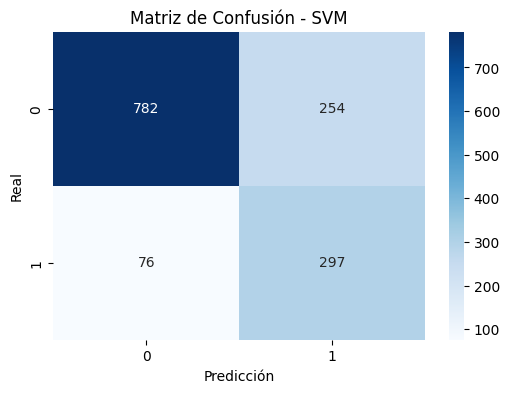

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


**Curvas ROC y AUC**

In [ ]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objs as go

svm_prob = svm_model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, svm_prob)
roc_auc = auc(fpr, tpr)

fig_roc = go.Figure()
fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name="ROC"))
fig_roc.add_trace(go.Scatter(x=[0,1], y=[0,1], mode="lines", name="Azar", line=dict(dash="dash")))

fig_roc.update_layout(title=f"Curva ROC - SVM (AUC={roc_auc:.3f})",
                      xaxis_title="False Positive Rate",
                      yaxis_title="True Positive Rate")

fig_roc.show()
